In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import external libraries
import numpy as np
import pandas as pd
from pathlib import Path
from parallel_run import *
from utils import *
# Settings
%matplotlib inline
np.set_printoptions(precision=3)

## Simple yet powerful irradiance toolbox
ViewFactors simulation in 2D.

I will focus on the simulation of irradiance in-plane of array (front and back faces). Simulation of the phisical inverter technology is already well known and available.

# Cadarache

## Fix

In [8]:
PATH = Path('../data')
tmy_file = PATH/'Cadarache.csv'
xls_file = PATH/'3d_VF_model_output.xlsx'  #output of the 3d VF simulations

In [9]:
cadarache_fix_3d = pd.read_excel(xls_file, header=10, index_col=0, usecols=list(range(1,14)), nrows=9).T

In [11]:
cadarache_tracked_3d = pd.read_excel(xls_file, header=10+12, index_col=0, usecols=list(range(1,14)), nrows=9).T

Here we define the system to simulate, we have to enter the phisical parameters of the geometry and the material condition of the ground and modules.
- `h_ground=1` : is the height from the ground for the bottom module for fixed system, or the axis height for tracked systems.
- `n_modules_vertically=2` : The number of modules stacked in landsacape but vertically.
- `module_size=(1.69, 1.01)` : The module dimesions
- `surface_tilt=38` : The tilt of the fixed config in degrees.
- `axis_azimuth=0,` : The axis orientation, 0 is north, measured in degrees clockwise. 
- `surface_azimuth=180` : The surface roientation, 180 is facing south.
- `n_pvrows=1` : How many rows are we modelling.
- `tracking=False`: If we want to track. (backtracking is supported)
- `gcr=0.5` : As we don't define distance between rows, ground coverage ratio is computed from:
$$gcr = \frac{\text{footprint}}{\text{distance_between_rows}}$$

In [13]:
pvarray_parameters = system_def(h_ground=1); pvarray_parameters

{'n_pvrows': 1,
 'pvrow_height': 1.6218180900789148,
 'pvrow_width': 2.02,
 'tracking': False,
 'axis_azimuth': 0,
 'surface_tilt': 38,
 'surface_azimuth': 180,
 'albedo': 0.4,
 'gcr': 0.5,
 'rho_front_pvrow': 0.075,
 'rho_back_pvrow': 0.075,
 'cut': {0: {'front': 3, 'back': 6}}}

We construct the necesarry data from the tmy file, and a sun position model, we also compute the optimal tracking if `tracked=True`.
We could also make more precise simulation using data with a infer timestep.

In [14]:
data_fix = get_data(tmy_file, pvarray_parameters); data_fix.head()

INFO:parallel_run:Correcting 220 indexes, Total GHI discarded = 169.0


,ghi,dni,dhi,zenith,azimuth,surface_tilt,surface_azimuth,albedo
datetime,,,,,,,,
2018-01-01 00:00:00,0.0,-0.0,0.0,158.936959,12.696340,38,180,0.4
2018-01-01 01:00:00,0.0,-0.0,0.0,153.612487,44.870203,38,180,0.4
2018-01-01 02:00:00,0.0,-0.0,0.0,144.668185,65.628521,38,180,0.4
2018-01-01 03:00:00,0.0,-0.0,0.0,134.318938,79.792082,38,180,0.4
2018-01-01 04:00:00,0.0,-0.0,0.0,123.524151,90.889563,38,180,0.4


We can see our system, with the shadows

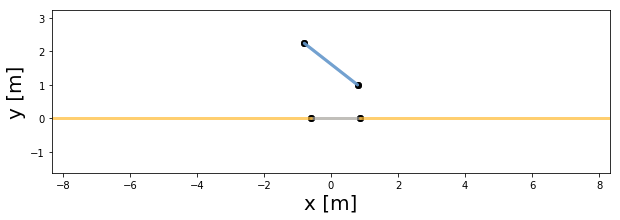

In [15]:
debug_pvarray(data_fix, pvarray_parameters)

Compute the whole year, `parallel` is the number of process to launch.

In [16]:
res = pv_engine_run(data_fix, pvarray_parameters, parallel=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8760/8760 [00:24<00:00, 353.85it/s]


In [17]:
report = report_flo(data_fix, res); report.T

,Janvier,Fevrier,Mars,Avril,Mai,Juin,Juillet,Août,Septembre,Octobre,Novembre,Décembre
ghi,63.969450,72.105000,121.197050,155.664000,195.633900,230.522000,247.304000,207.249100,141.130000,97.297000,65.254000,51.640400
dhi,22.010150,30.376000,48.426900,58.706000,71.067350,70.765000,59.951000,59.468500,52.164000,36.824000,26.444000,19.814000
qinc_front,128.805992,116.385688,160.594003,177.367335,195.680118,220.342031,243.330219,226.377910,177.105247,145.228153,119.555980,109.606668
qinc_back_high,21.474096,24.481164,39.564397,50.125274,63.611987,72.600496,77.158276,65.016385,45.551445,32.015186,22.079369,17.649492
qinc_back_low,20.916360,23.759368,38.311828,47.810931,60.688329,68.866524,73.253864,62.025382,43.598433,30.988434,21.426182,17.282723
bf_gain,2.657563,3.770634,5.564069,7.208474,11.311869,11.035482,11.866229,9.423692,5.521312,4.584626,3.082357,2.553960


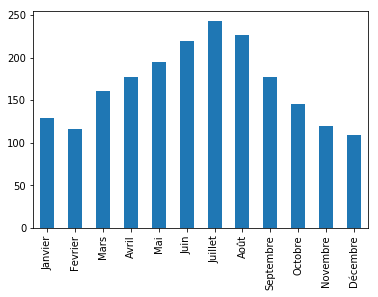

In [20]:
report.qinc_front.plot.bar()

We can also compare with a SoA (NREL pvlib) model that includes AOI losses, AirMass Losses:

In [21]:
effective_irradiance = get_pvlib_eirrad(data_fix)
eii = group_monthly(effective_irradiance)/1000
eii_month =  reindex_monthly_fr(eii)

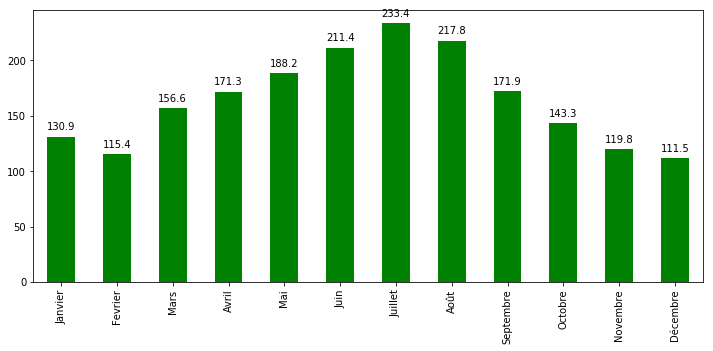

In [22]:
ax = eii_month.plot.bar(figsize=(12,5), color='green')
add_value_labels(ax, spacing=5)

## Results comparison between 2d and 3 approach + NREL reference
We will plot results of the 2d model against the 3d model (Florent Haffner), we add the NREL front face irradiation method.

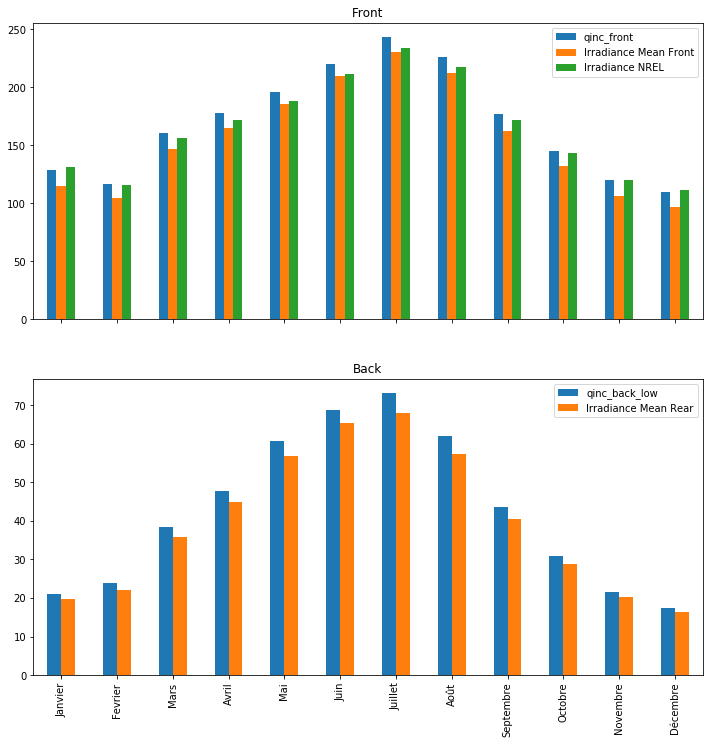

In [25]:
plot_compare(data_fix, res, cadarache_fix_flo)

Bifacial Gain

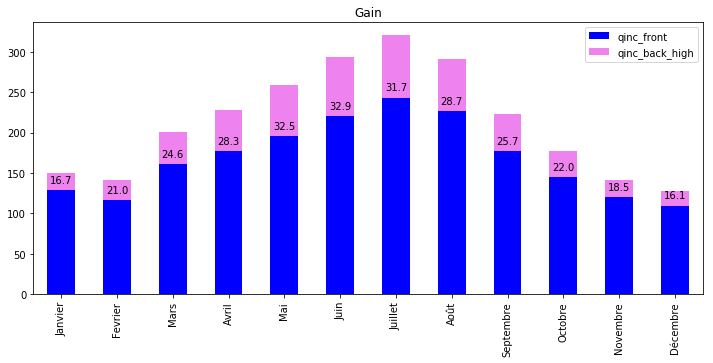

In [26]:
plot_gain(res.qinc_front, res.qinc_back_high)

## Tracked

In [27]:
pvarray_parameters = system_def(h_ground=1.8, tracking=True)
data_tracked = get_data(tmy_file, pvarray_parameters); data_tracked['21 Dec 2018']

INFO:parallel_run:Correcting 220 indexes, Total GHI discarded = 169.0
C:\Users\tc256760\AppData\Local\Continuum\miniconda3\envs\pvfactors\lib\site-packages\pvlib\tracking.py:473: RuntimeWarning: invalid value encountered in arccos
  aoi = np.degrees(np.arccos(np.abs(np.sum(sun_vec*panel_norm, axis=0))))
C:\Users\tc256760\AppData\Local\Continuum\miniconda3\envs\pvfactors\lib\site-packages\pvlib\tracking.py:568: RuntimeWarning: invalid value encountered in remainder
  surface_azimuth = surface_azimuth % 360
C:\Users\tc256760\AppData\Local\Continuum\miniconda3\envs\pvfactors\lib\site-packages\pvlib\tracking.py:572: RuntimeWarning: invalid value encountered in arccos
  surface_tilt = 90 - np.degrees(np.arccos(dotproduct))


,ghi,dni,dhi,zenith,azimuth,surface_tilt,surface_azimuth,albedo
datetime,,,,,,,,
2018-12-21 00:00:00,0.0,-0.00,0.0,159.090894,16.399279,0.000000,0.0,0.4
2018-12-21 01:00:00,0.0,-0.00,0.0,153.233013,47.733179,0.000000,0.0,0.4
2018-12-21 02:00:00,0.0,-0.00,0.0,144.042100,67.655334,0.000000,0.0,0.4
2018-12-21 03:00:00,0.0,-0.00,0.0,133.601332,81.360488,0.000000,0.0,0.4
2018-12-21 04:00:00,0.0,-0.00,0.0,122.790399,92.227015,0.000000,0.0,0.4
2018-12-21 05:00:00,0.0,-0.00,0.0,112.044383,101.921823,0.000000,0.0,0.4
2018-12-21 06:00:00,0.0,-0.00,0.0,101.667364,111.367969,0.000000,0.0,0.4
2018-12-21 07:00:00,0.0,-0.00,0.0,91.952439,121.182568,0.000000,0.0,0.4
2018-12-21 08:00:00,113.0,509.90,41.0,83.240526,131.842583,80.960078,90.0,0.4


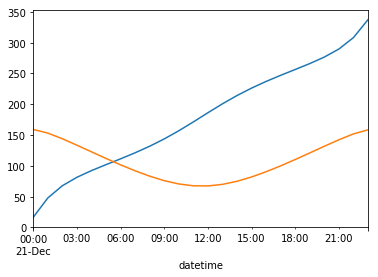

In [28]:
data_tracked['21 Dec 2018'].azimuth.plot()
data_tracked['21 Dec 2018'].zenith.plot()

In [30]:
res2 = pv_engine_run(data_tracked, pvarray_parameters, parallel=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8760/8760 [00:25<00:00, 341.74it/s]


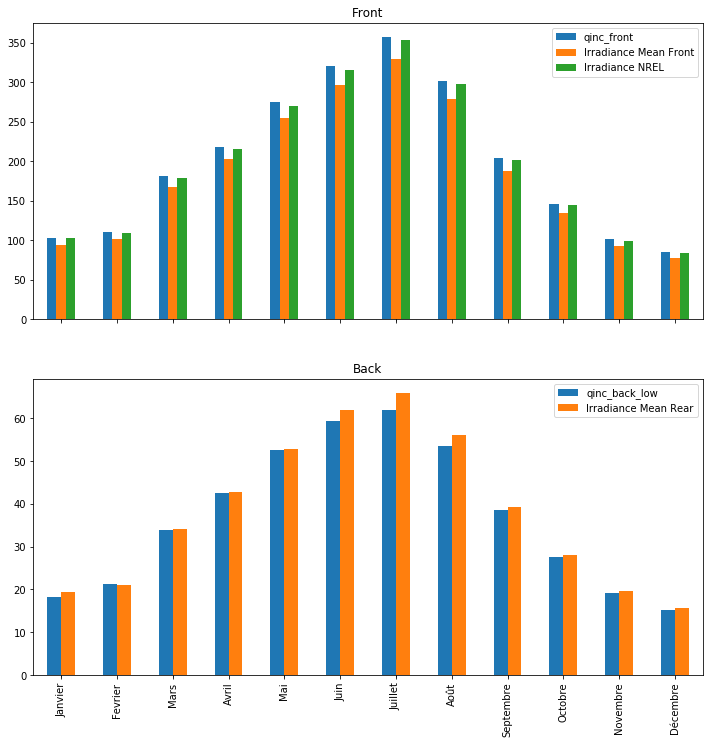

In [31]:
plot_compare(data_tracked, res2, cadarache_tracked_flo)

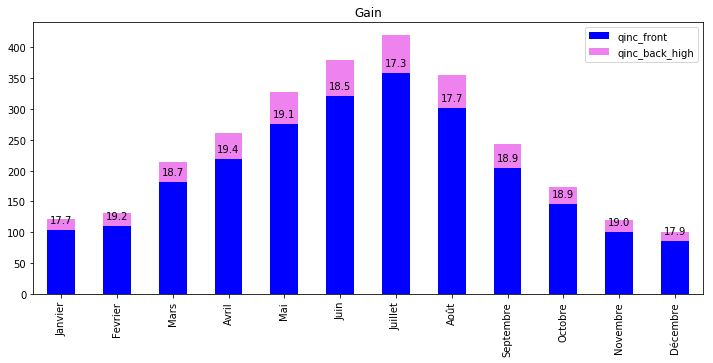

In [32]:
plot_gain(res2.qinc_front, res2.qinc_back_high)

# A More realistic Example
## Fix

In [33]:
pvarray_parameters = system_def(h_ground=1, n_pvrows=3);

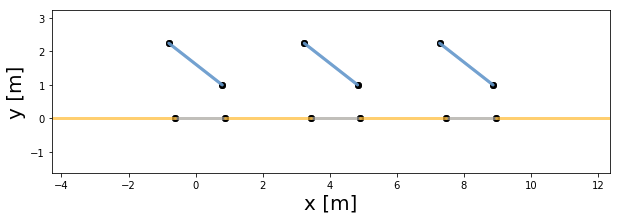

In [34]:
debug_pvarray(data_fix, pvarray_parameters)

In [35]:
res3 = pv_engine_run(data_fix, pvarray_parameters, parallel=6)

INFO:pvfactors.run:Parallel calculation elapsed time: 83.05294895172119 sec


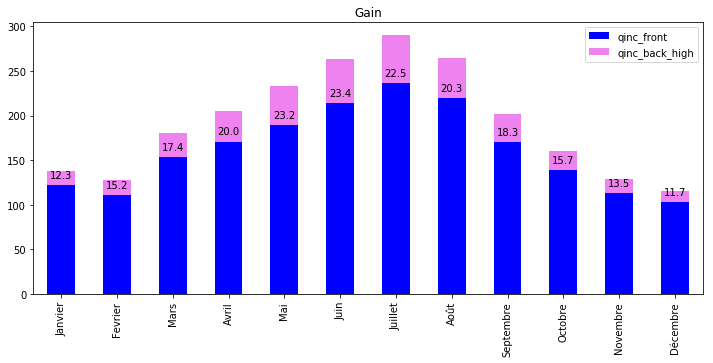

In [36]:
plot_gain(res3.qinc_front, res3.qinc_back_high)

## Tracked

In [37]:
pvarray_parameters = system_def(h_ground=1.8, tracking=True, n_pvrows=3)

In [39]:
res4 = pv_engine_run(data_tracked, pvarray_parameters, parallel=6)

INFO:pvfactors.run:Parallel calculation elapsed time: 80.68236637115479 sec


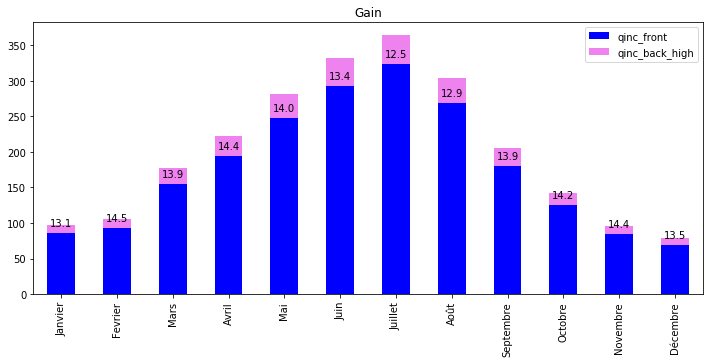

In [40]:
plot_gain(res4.qinc_front, res4.qinc_back_high)

## TOTAL PROD in $MWh/{m^2}$ per year

In [41]:
(res4.qinc_front.sum()+res4.qinc_back_high.sum())/1e6

2.407256328647536